# Final Model


based on model 5 in the modeling notebook

In [52]:
import pandas as pd
import numpy as np

import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_squared_log_error, SCORERS

from xgboost import XGBRegressor

In [12]:
rs = 123

## Data wrangling

### Import data

In [13]:
# import necessary data
df_data = pd.read_csv('../data/train_wide_with_hours.csv')
df_daily_means = pd.read_csv('../data/train_daily_mean.csv')

### Feature engineering

In [14]:
features = df_daily_means.columns[2:]
df_daily_means = df_daily_means.pivot(index='ID', values=features, columns='day').reset_index()
df_daily_means = df_daily_means.drop('ID', axis=1, level=0)

In [15]:
df_data = pd.concat([df_data, df_daily_means], axis=1)
df_data

,ID,location,target,max_temp,min_temp,mean_temp,std_temp,var_temp,median_temp,ptp_temp,...,"(wind_spd, 1.0)","(wind_spd, 2.0)","(wind_spd, 3.0)","(wind_spd, 4.0)","(wind_spd, 5.0)","(atmos_press, 1.0)","(atmos_press, 2.0)","(atmos_press, 3.0)","(atmos_press, 4.0)","(atmos_press, 5.0)"
0,ID_train_0,C,45.126304,27.208333,19.275000,22.299527,2.594011,6.728895,21.358333,7.933333,...,NaN,NaN,NaN,NaN,0.677348,NaN,NaN,NaN,NaN,87.752434
1,ID_train_1,D,79.131702,33.616667,17.983333,24.679063,4.266955,18.206903,23.791667,15.633333,...,0.786433,1.014201,0.805000,1.015694,0.879410,90.360500,90.380660,90.441806,90.429653,90.539896
2,ID_train_10,A,32.661304,31.841667,18.458333,24.112317,3.776377,14.261020,23.304167,13.383333,...,NaN,1.167222,0.948542,1.130590,1.020764,88.584967,88.488696,88.353993,88.376979,88.296007
3,ID_train_100,A,53.850238,27.491667,16.941667,20.845273,3.080140,9.487259,19.541667,10.550000,...,1.423250,1.354514,2.006563,1.961875,1.038472,88.401000,88.254583,88.356076,88.488229,88.383681
4,ID_train_1000,A,177.418750,28.750000,17.525000,21.870732,3.286870,10.803515,20.950000,11.225000,...,0.762800,0.521111,0.629773,NaN,NaN,88.541633,88.546389,88.481553,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15534,ID_train_9995,A,44.850286,27.841667,16.550000,20.573209,2.987662,8.926124,19.458333,11.291667,...,1.143125,0.981726,1.336429,0.915312,0.752396,88.347367,88.222604,88.321632,88.500868,88.523681
15535,ID_train_9996,E,24.330455,29.550000,18.991667,23.546832,2.614979,6.838117,23.208333,10.558333,...,1.315900,1.199201,0.981157,1.257986,1.046146,88.488733,88.519132,88.410382,88.371840,88.386910
15536,ID_train_9997,D,38.972128,34.108333,16.950000,24.637083,4.352597,18.945097,24.179167,17.158333,...,0.856533,0.943646,1.035069,1.046111,1.249896,90.570233,90.627639,90.537951,90.422187,90.451979
15537,ID_train_9998,D,41.720952,30.900000,15.891667,23.472934,4.651403,21.635547,23.066667,15.008333,...,0.869767,1.258021,1.152535,0.709047,0.771269,90.445100,90.447361,90.512014,90.520956,90.507292


### Split data into features and target

In [16]:
# get target
y = np.log10(df_data['target']+1)
# get features
X = df_data.iloc[:, 52:] #np.log10(df_train.iloc[:, 52:]+1)
# extract locations and encode
loc_dummies = pd.get_dummies(df_data['location'], drop_first=True)
# add to feature matrix
X = pd.concat([X, loc_dummies], axis=1)

### Generate Train/Test sets

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=rs)

## Base model

### Train base model

In [56]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [57]:
y_pred = xgb.predict(X_test)

### Evaluate base model

In [28]:
xgb.get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_bin': 256,
 'max_cat_threshold': 64,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

RMSLE with log(features) w/o hours as feature and log(target): 0.06488672739344391
RMSE with log(features) w/o hours as feature and log(target):  28.77078268283199


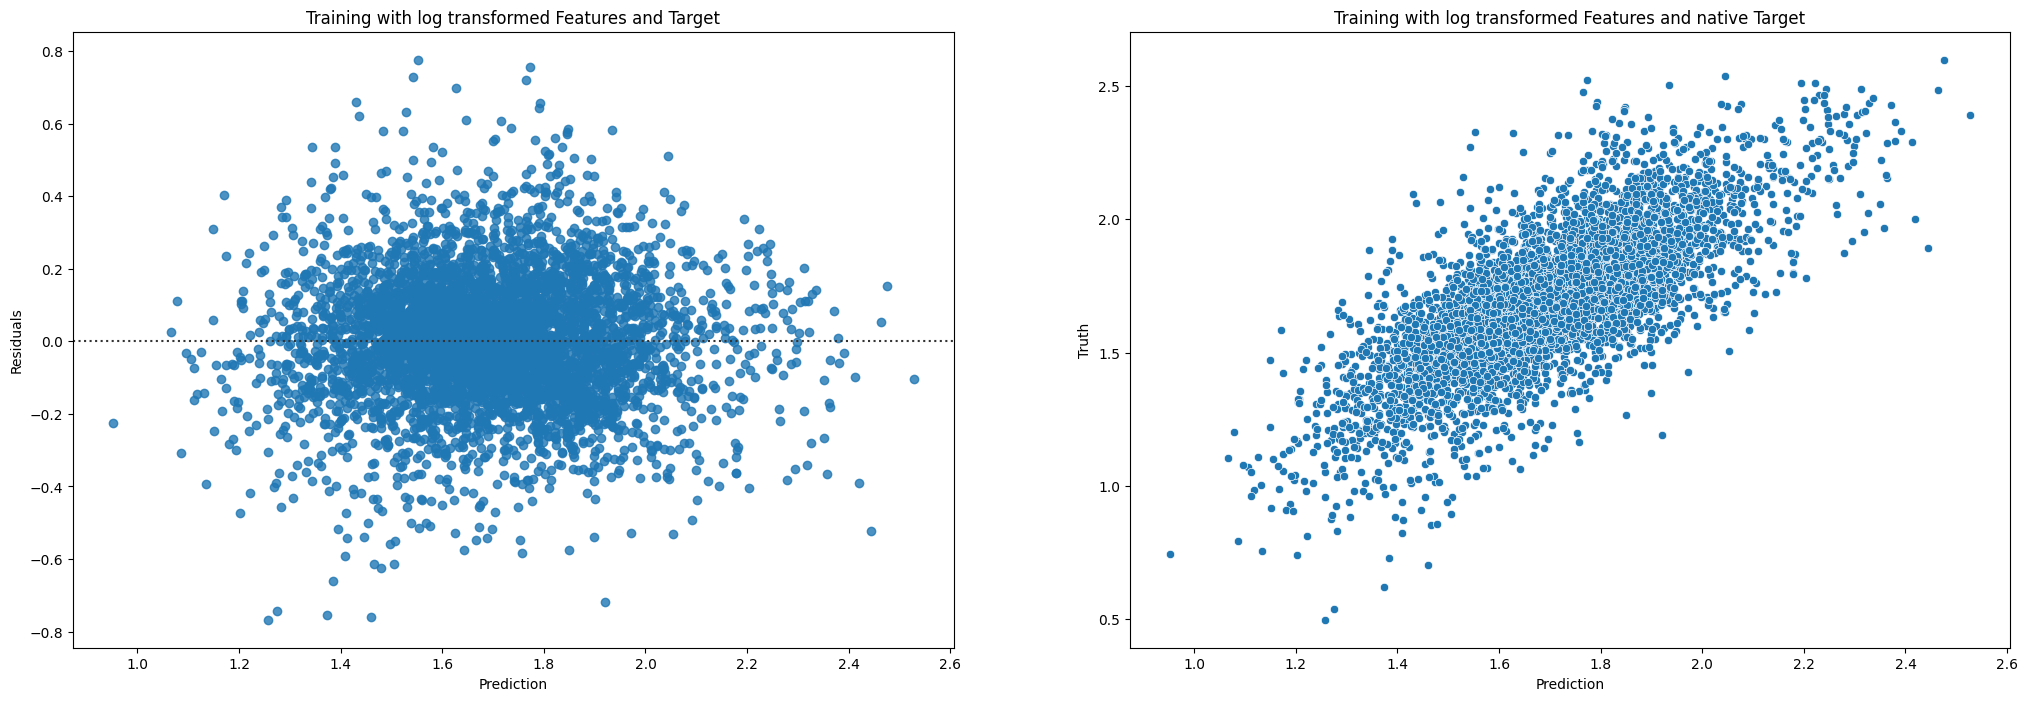

In [58]:
# print RMSE and RMSLE
print(f"RMSLE with log(features) w/o hours as feature and log(target): {mean_squared_log_error(y_test, y_pred, squared=False)}")
print(f"RMSE with log(features) w/o hours as feature and log(target):  {mean_squared_error(y_true=np.power(10, y_test), y_pred=np.power(10, y_pred), squared=False)}")

# plot residual distribution
fig, ax = plt.subplots(1, 2, figsize=(25, 8))

g1 = sns.residplot(x=y_pred, y=y_test, ax=ax[0])
g2 = sns.scatterplot(x=y_pred, y=y_test, ax=ax[1])

g1.set_title('Training with log transformed Features and Target')
g2.set_title('Training with log transformed Features and native Target')

g1.set_ylabel('Residuals')
g1.set_xlabel('Prediction')
g2.set_ylabel('Truth')
g2.set_xlabel('Prediction');

## Tune Base model

In [45]:
params = {
    'learning_rate': [0.1, 0.300000012, 1],
    'max_depth': [1, 6, 10, 50],
    'max_leaves': [0, 10, 100],
    'n_estimators': [10, 30, 100],
    'reg_alpha': [0, 0.01, 0.001],
}
xgb = XGBRegressor()
gscv = GridSearchCV(estimator=xgb, param_grid=params, scoring='neg_mean_squared_log_error', n_jobs=-1)
rscv = RandomizedSearchCV(estimator=xgb, param_distributions=params, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1, n_iter=10, random_state=rs)

In [46]:
# gscv.fit(X_train, y_train)
rscv.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          min_child_weight=None, missing=nan,
                             

In [48]:
final_model = rscv.best_estimator_

In [50]:
y_pred = final_model.predict(X_test)

RMSLE with log(features) w/o hours as feature and log(target): 0.06045844144065285
RMSE with log(features) w/o hours as feature and log(target):  27.47301918535412


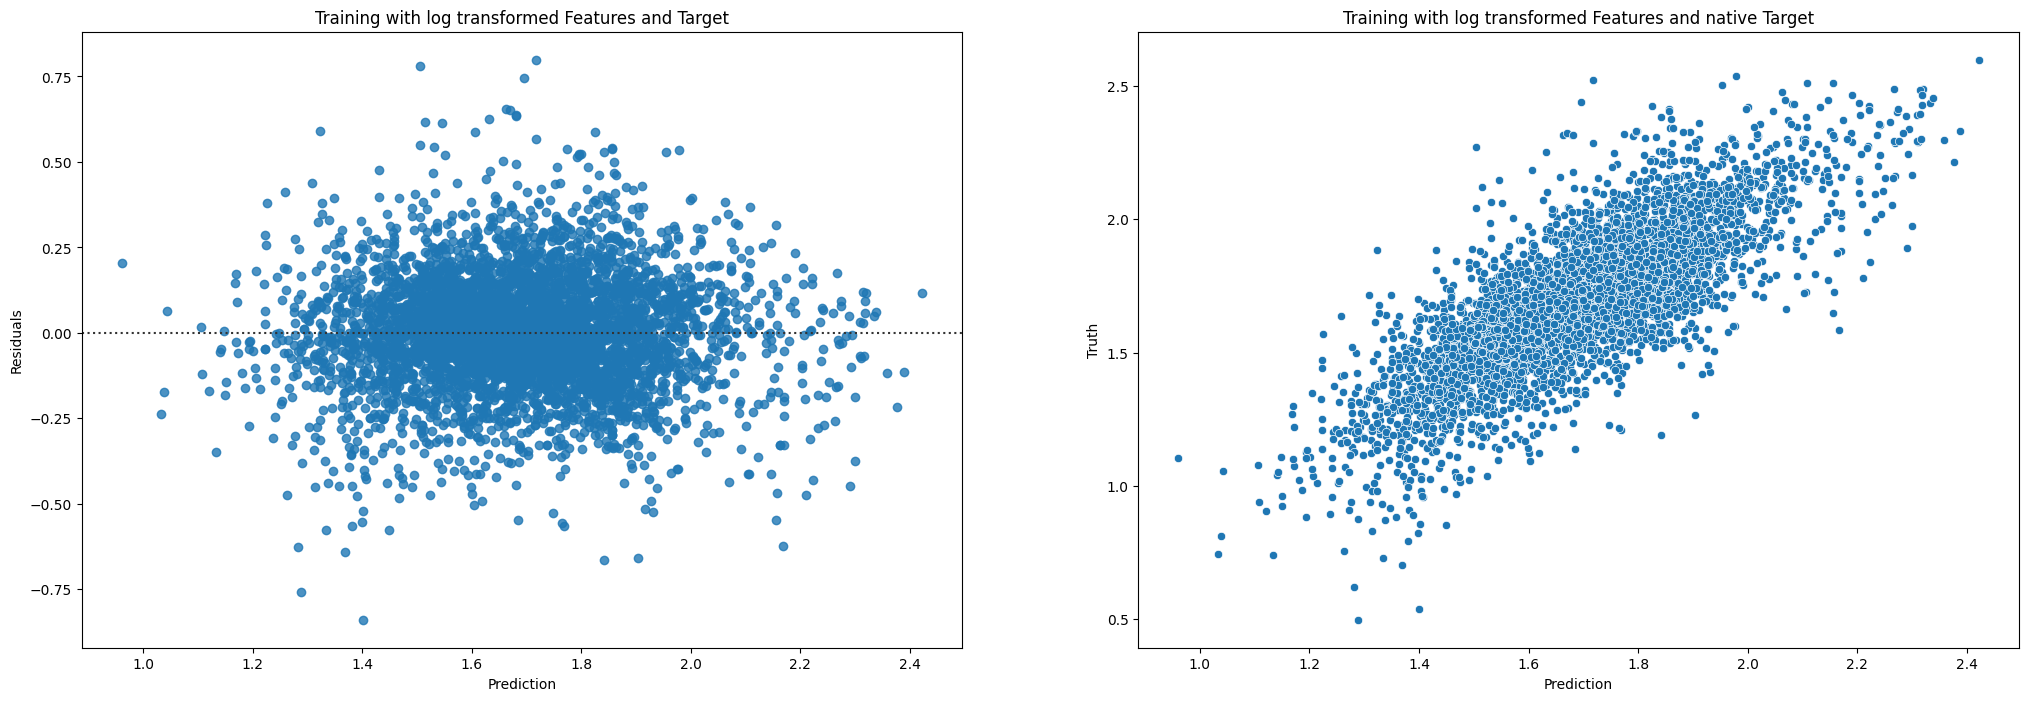

In [51]:
# print RMSE and RMSLE
print(f"RMSLE with log(features) w/o hours as feature and log(target): {mean_squared_log_error(y_test, y_pred, squared=False)}")
print(f"RMSE with log(features) w/o hours as feature and log(target):  {mean_squared_error(y_true=np.power(10, y_test), y_pred=np.power(10, y_pred), squared=False)}")

# plot residual distribution
fig, ax = plt.subplots(1, 2, figsize=(25, 8))

g1 = sns.residplot(x=y_pred, y=y_test, ax=ax[0])
g2 = sns.scatterplot(x=y_pred, y=y_test, ax=ax[1])

g1.set_title('Training with log transformed Features and Target')
g2.set_title('Training with log transformed Features and native Target')

g1.set_ylabel('Residuals')
g1.set_xlabel('Prediction')
g2.set_ylabel('Truth')
g2.set_xlabel('Prediction');

In [55]:
with open(f'../models/model_final_1.p', 'wb') as f:
    pickle.dump(final_model, f)